In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

## Basic Neural Network classification of tumours

In [2]:
df = pd.read_csv('DATA/cancer_classification.csv')

In [3]:
df.info() # checking null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
mean radius,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
mean texture,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
mean perimeter,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
mean area,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
mean smoothness,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
mean compactness,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
mean concavity,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
mean concave points,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
mean symmetry,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
mean fractal dimension,569.0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744


<AxesSubplot:xlabel='benign_0__mal_1', ylabel='count'>

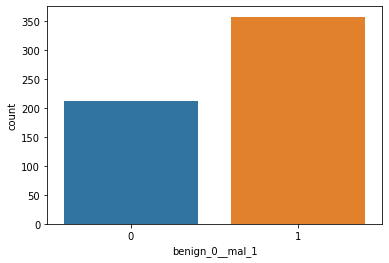

In [5]:
sns.countplot(x='benign_0__mal_1', data=df)  # checking label counts

<AxesSubplot:>

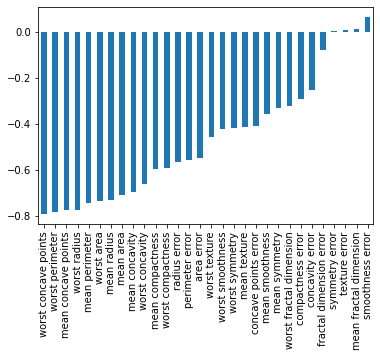

In [6]:
# visually checking correlation of features against label
df.corr()['benign_0__mal_1'][:-1].sort_values().plot(kind='bar')

<AxesSubplot:>

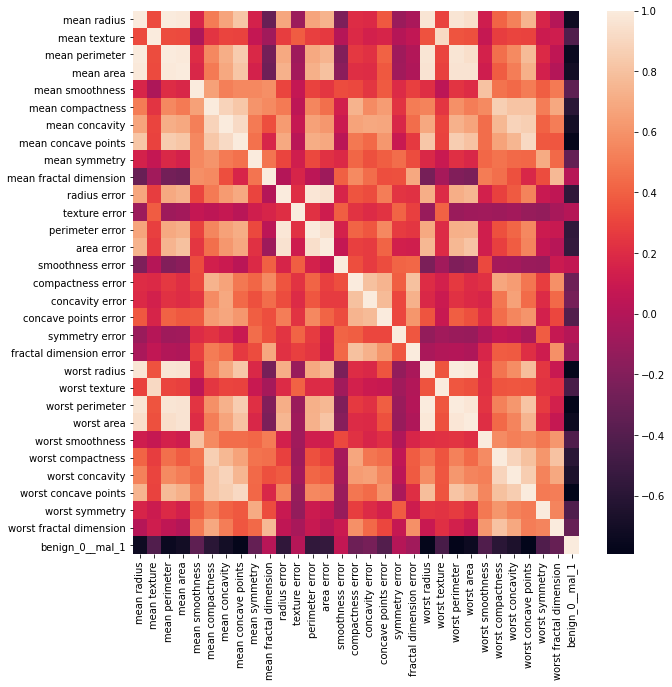

In [7]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr())  # correlation heatmap of features

### Training the model

In [8]:
X = df.drop('benign_0__mal_1', axis=1).values  # removing label from df
y = df['benign_0__mal_1'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

# scaling the data

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential()
model.add(Dense(units=30, activation='relu'))
model.add(Dense(units=15, activation='relu'))
model.add(Dense(units=1, activation='sigmoid')) # sigmoid since binary

model.compile(loss='binary_crossentropy', optimizer='adam')
model.fit(x=X_train, y=y_train, epochs=500, verbose=0, validation_data=(X_test, y_test))

<AxesSubplot:>

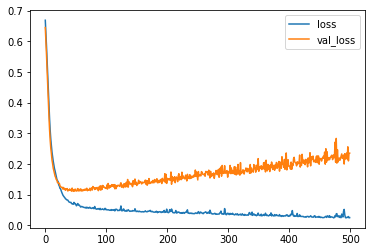

In [9]:
loss = pd.DataFrame(model.history.history)  # checking loss for overfitting
loss.plot()

Past the point at which the graph of loss and validation loss diverge, the model is overfitting, hence epochs too high.

Redefining model, we can use callbacks to prevent overfitting.

In [10]:
X = df.drop('benign_0__mal_1', axis=1).values  # removing label from df
y = df['benign_0__mal_1'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

# scaling the data

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential()
model.add(Dense(units=30, activation='relu'))
model.add(Dense(units=15, activation='relu'))
model.add(Dense(units=1, activation='sigmoid')) # sigmoid since binary

model.compile(loss='binary_crossentropy', optimizer='adam')

earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
model.fit(x=X_train, y=y_train, epochs=500, verbose=0, validation_data=(X_test, y_test), callbacks=[earlystop])



Epoch 00084: early stopping


This allows us to use any arbitrary value for epochs knowing the callback will prevent overfitting

<AxesSubplot:>

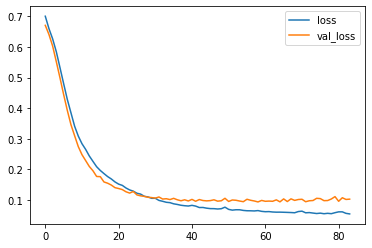

In [11]:
modelloss = pd.DataFrame(model.history.history)
modelloss.plot()

We can further prevent overfitting by using dropout layers, which essentially drop out a percentage of neurons from each layer

In [12]:
#redefining the new model
model = Sequential()
model.add(Dense(units=30, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=15, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1, activation='sigmoid')) # sigmoid since binary

model.compile(loss='binary_crossentropy', optimizer='adam')

earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
model.fit(x=X_train, y=y_train, epochs=500, verbose=0, validation_data=(X_test, y_test), callbacks=[earlystop])


Epoch 00152: early stopping


<AxesSubplot:>

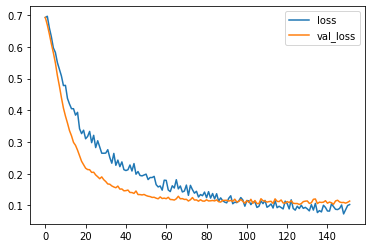

In [13]:
loss = pd.DataFrame(model.history.history)
loss.plot()

This is an improvement to both previous graphs, since both losses are being minimized at the same rate. 

## Making predictions on the test data set using the model

In [14]:
predictions = model.predict_classes(X_test)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95        55
           1       0.98      0.97      0.97        88

    accuracy                           0.97       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.97      0.97      0.97       143

[[53  2]
 [ 3 85]]


/usr/local/lib64/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


The model was able to predict malginiancy with 97% accuracy